## Blackboard Instructions:
- Run the feature selection notebook on the ~2000 candidate variables.
- Try different combinations of num_filter and num_wrapper.
- Turn in
- The executed notebook.
- The list of final variables along with their univariate KS’s.
- The plot showing model performance vs # variables.
- Make sure your final FDR@3% (Fraud Detection Rate at 3%) is around .6. If it's not, keep trying different values of num_filter.

This feature selection notebook does a filter followed by a wrapper for a binary dependent variable (binary classification). It's capable of doing the filter on more than one file. The variable files are called vars1.csv, vars2.csv ... Or you can make the input file name(s) anything you want.

The filter runs separately on each vars file and keeps the top num_filter variables from each file. If there are more than one vars files we'll again select the top num_filter variables across all the vars.csv files.

If balance = 0 the entire files are used. If balance != 0 then balance is the RATIO OF BADS TO GOODS retained for the rest of the feature selection. We keep all the rare class (bads) and downsample the goods. I think in general it's better to keep balance = 0.

I've got an annoying warning message from the wrapper and I can't figure out how to get rid of it. If anybody figures this out please send a message to stevecoggeshall@gmail.com

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as sps
import matplotlib.pyplot as plt
import datetime as dt
import gc
from sklearn.ensemble import RandomForestClassifier
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from lightgbm import LGBMClassifier
%matplotlib inline
start_time = dt.datetime.now()

In [2]:
# set some parameters
num_files = 1
# I recommend set num_filter to be about 10 to 20% of the original # variables
num_filter = 240
# I recommend set num_wrapper to be about 50, then look for a saturation of the model performance as variables are added
# Then you can run it again with num_wrapper just a bit above this saturation point, not more than about twice this saturation number
num_wrapper = 20
balance = 0
detect_rate = .03
index_name = 'record'
y_name = 'fraud_label'
good_label = 0
bad_label = 1

## Run a filter on all the files

In [3]:
%%time
filter_score_df_list = []
for i in range(num_files):
#     file_name = "vars"+str(i+1)+'.csv'
    file_name = 'vars.csv'
    df = pd.read_csv(file_name)
    print("********** working on",file_name,"size is",df.shape)
    df = df.set_index(index_name) 
    df = df[df.index <= 833507] # remove the last two months as the out-of-time data (OOT)
    df = df[df.index >= 38511] # remove the first 2 weeks of records since their variables aren't well formed
    df['RANDOM'] = np.random.ranf(len(df)) # add a random number variable to make sure it doesn't come up as important
    goods = df[df[y_name] == good_label]
    bads = df[df[y_name] == bad_label]
    del df # don't need this file anymore
    num_goods = len(goods)
    num_bads = len(bads)
    num_vars = len(bads.columns)-2
    if(balance != 0):
        if(i == 0):
            num_goods_desired = int(min(num_goods,num_bads*balance))
            goods = goods.sample(n=num_goods_desired,random_state=1)
            goods_keep = list(goods.index)
            goods_keep.sort()
    
        if(i > 0):
            goods = goods.loc[goods_keep] 
            
    df_sampled = pd.concat([goods,bads])
    df_sampled.sort_index(inplace=True)
    filter_score = pd.DataFrame(np.zeros((num_vars+1,2)))
    filter_score.columns = ['variable','filter score']   
    j = 0
    for column in df_sampled:
        filter_score.loc[j,'variable'] = column
        filter_score.loc[j,'filter score'] = sps.ks_2samp(goods[column],bads[column])[0]
        j = j+1
        if j%100 == 0:
            print(j)

    filter_score.sort_values(by=['filter score'], ascending=False, inplace=True)
    vars_keep = list(filter_score['variable'][1:num_filter+1]) 
    print(file_name,filter_score.head(20))
    if(i == 0): # if first time through need to initialize some stuff
        Y = pd.DataFrame(df_sampled[y_name], index=df_sampled.index)
        df_top = df_sampled.filter(vars_keep, axis=1)
            
    if(i > 0): # if more than one variable file we use this loop
        data_new_top = df_sampled.filter(vars_keep, axis=1)
        df_top = pd.concat([df_top,data_new_top], axis=1)

    filter_score_df_list.append(filter_score)
    
    del goods # delete these before starting the next file, if any
    del bads
    gc.collect()
filter_score = pd.concat(filter_score_df_list)

********** working on vars.csv size is (1000000, 2242)
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
vars.csv                                             variable  filter score
0                                        fraud_label      1.000000
2128                     max_count_by_fulladdress_30      0.359914
2108                         max_count_by_address_30      0.359215
2107                          max_count_by_address_7      0.343335
2127                      max_count_by_fulladdress_7      0.343052
10                                 address_day_since      0.334140
45                             fulladdress_day_since      0.333269
16                                  address_count_30      0.332648
51                              fulladdress_count_30      0.331969
2126                      max_count_by_fulladdress_3      0.329538
2106                          max_count_by_address_3      0.329445
15                             

In [4]:
filter_score.sort_values(by=['filter score'], ascending=False, inplace=True)
filter_score.reset_index(drop=True,inplace=True)

In [5]:
filter_score.head(30)

,variable,filter score
0,fraud_label,1.000000
1,max_count_by_fulladdress_30,0.359914
2,max_count_by_address_30,0.359215
3,max_count_by_address_7,0.343335
4,max_count_by_fulladdress_7,0.343052
5,address_day_since,0.334140
6,fulladdress_day_since,0.333269
7,address_count_30,0.332648
8,fulladdress_count_30,0.331969
9,max_count_by_fulladdress_3,0.329538


In [6]:
filter_score.tail(10)

,variable,filter score
2232,ssn_fulladdress_unique_count_for_ssn_firstname_1,0.000004
2233,ssn_zip5_unique_count_for_name_fulladdress_30,0.000003
2234,homephone_name_dob_unique_count_for_zip5_0,0.000003
2235,ssn_zip5_unique_count_for_ssn_lastname_1,0.000003
2236,ssn_dob_unique_count_for_ssn_firstname_0,0.000003
2237,ssn_zip5_unique_count_for_address_14,0.000002
2238,name_fulladdress_unique_count_for_zip5_30,0.000001
2239,ssn_lastname_unique_count_for_name_0,0.000001
2240,ssn_fulladdress_unique_count_for_ssn_firstname_60,0.000001
2241,fulladdress_unique_count_for_address_0,0.000000


In [7]:
filter_score.shape

(2242, 2)

In [8]:
filter_score.head(80).to_csv('filter_top.csv')
vars_keep = list(filter_score['variable'][num_files:num_filter+3])
print(i,' vars_keep:',vars_keep)

0  vars_keep: ['max_count_by_fulladdress_30', 'max_count_by_address_30', 'max_count_by_address_7', 'max_count_by_fulladdress_7', 'address_day_since', 'fulladdress_day_since', 'address_count_30', 'fulladdress_count_30', 'max_count_by_fulladdress_3', 'max_count_by_address_3', 'address_count_14', 'fulladdress_count_14', 'max_count_by_address_1', 'max_count_by_fulladdress_1', 'address_count_7', 'fulladdress_count_7', 'address_unique_count_for_name_homephone_60', 'address_count_0_by_30', 'address_unique_count_for_homephone_name_dob_60', 'fulladdress_count_0_by_30', 'fulladdress_unique_count_for_ssn_homephone_60', 'address_unique_count_for_ssn_zip5_60', 'address_unique_count_for_ssn_name_60', 'fulladdress_unique_count_for_name_homephone_60', 'address_unique_count_for_ssn_homephone_60', 'fulladdress_unique_count_for_homephone_name_dob_60', 'fulladdress_unique_count_for_dob_homephone_60', 'address_unique_count_for_ssn_firstname_60', 'address_unique_count_for_ssn_name_dob_60', 'address_unique_c

In [9]:
vars_keep_df = pd.DataFrame({'col':vars_keep})
vars_keep_df.to_csv('vars_keep_filter.csv',index=False)
df_keep = df_top.filter(vars_keep, axis=1)
df_keep.head()

,max_count_by_fulladdress_30,max_count_by_address_30,max_count_by_address_7,max_count_by_fulladdress_7,address_day_since,fulladdress_day_since,address_count_30,fulladdress_count_30,max_count_by_fulladdress_3,max_count_by_address_3,...,zip5_unique_count_for_dob_homephone_3,zip5_unique_count_for_homephone_name_dob_3,zip5_unique_count_for_name_homephone_3,zip5_unique_count_for_ssn_dob_3,zip5_unique_count_for_ssn_name_dob_3,zip5_unique_count_for_dob_3,zip5_unique_count_for_ssn_3,zip5_unique_count_for_ssn_lastname_3,zip5_unique_count_for_ssn_firstname_3,zip5_unique_count_for_ssn_name_3
record,,,,,,,,,,,,,,,,,,,,,
38511.0,14.0,14.0,10.0,10.0,0.0,0.0,12.0,12.0,6.0,6.0,...,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0
38512.0,1.0,1.0,1.0,1.0,365.0,365.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
38513.0,1.0,1.0,1.0,1.0,365.0,365.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
38514.0,1.0,1.0,1.0,1.0,365.0,365.0,1.0,1.0,1.0,1.0,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
38515.0,1.0,1.0,1.0,1.0,365.0,365.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [10]:
df_keep.shape

(794997, 240)

In [11]:
Y.head()

,fraud_label
record,
38511.0,1.0
38512.0,0.0
38513.0,0.0
38514.0,0.0
38515.0,0.0


In [12]:
Y = Y.values
Y_save = Y.copy()

In [13]:
# Y = np.array(Y)
X = df_keep
print(Y)

[[1.]
 [0.]
 [0.]
 ...
 [0.]
 [0.]
 [0.]]


In [14]:
print('time to here:', dt.datetime.now() - start_time)

time to here: 0:09:55.960297


In [15]:
print(X.shape,Y.shape)

(794997, 240) (794997, 1)


In [16]:
print(type(X),type(Y))

<class 'pandas.core.frame.DataFrame'> <class 'numpy.ndarray'>


In [17]:
# I'd like to define a scoring for the wrapper that's KS, but I haven't gotten around to this yet.
# def KSscore(classifier, x,y)
#     goods = 

In [18]:
def fdr(classifier, x, y, cutoff=detect_rate):
# Calculates FDR score for the given classifier on dataset x and y with cutoff value
# get the probability list from the given classifier
    return fdr_prob(y, classifier.predict_proba(x), cutoff)
def fdr_prob(y, y_prob, cutoff=detect_rate):
    if len(y_prob.shape) != 1:    # sometimes the proba list can contain many columns, one for each category
        y_prob = y_prob[:, -1:]   # only the last one (fraud_label==1) is used here.
    num_fraud = len(y[y == 1])    # count the total nunber of frauds   
# sort the proba list from high to low while retain the true (not predicted) fraud label
    sorted_prob = np.asarray(sorted(zip(y_prob, y), key=lambda x: x[0], reverse=True))
    cutoff_bin = sorted_prob[0:int(len(y) * cutoff), 1:]  # 3% cutoff
# return the FDR score (#fraud_in_cutoff / #total_fraud)
    return len(cutoff_bin[cutoff_bin == 1]) / num_fraud   

## Run a wrapper on the remaining top variables

In [19]:
%%time
import warnings 
warnings.filterwarnings("ignore", category=DeprecationWarning) 
# If you're doing forward selection it's enough to stop at num_wrapper variables. 
# If you're doing backward selection you need to go through all the variables to get a sorted list of num_wrapper variables.

# I can't figure out how to get rid of this annoying warning! I don't know what I'm doing wrong...

nfeatures = len(X.columns)
# clf = RandomForestClassifier(n_estimators=5) # simple, fast nonlinear model for the wrapper
clf = LGBMClassifier(n_estimators=20,num_leaves=3) # simple, fast nonlinear model for the wrapper
sfs = SFS(clf,k_features=num_wrapper,forward=True,verbose=0,scoring=fdr,cv=3,n_jobs=-1) # use for forward selection
# sfs = SFS(clf,k_features=1,forward=False,verbose=0,scoring=fdr,cv=3,n_jobs=-1) # use for backward selection
sfs.fit(X,Y)

/Users/joshuachang/opt/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


CPU times: user 19.1 s, sys: 22.4 s, total: 41.5 s
Wall time: 1h 35min 43s


SequentialFeatureSelector(cv=3,
                          estimator=LGBMClassifier(n_estimators=20,
                                                   num_leaves=3),
                          k_features=(20, 20), n_jobs=-1,
                          scoring=<function fdr at 0x7f7b8d929940>)

In [20]:
print('time to here:', dt.datetime.now() - start_time)

time to here: 1:45:39.472203


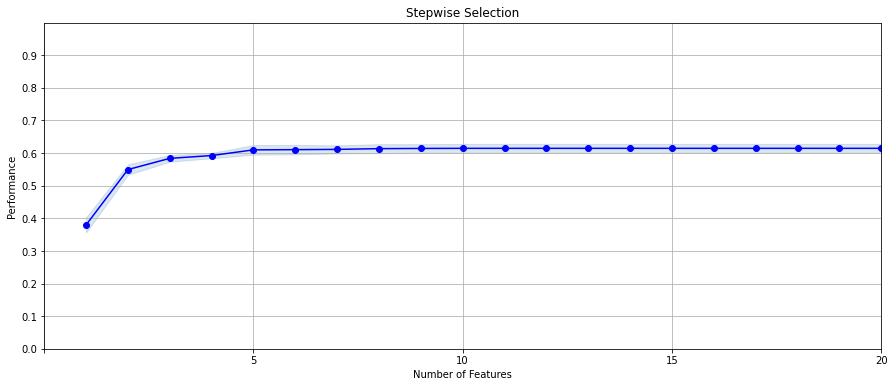

In [21]:
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
fig1 = plot_sfs(sfs.get_metric_dict(),kind='std_dev', figsize=(15, 6))
plt.xticks(np.arange(0, len(X.columns), step=5))
plt.yticks(np.arange(0,1,step=.1))
plt.ylim([0., 1])
plt.xlim(0,num_wrapper)
plt.title('Stepwise Selection')
plt.grid()
plt.savefig('performance_nvars.png')
plt.show()

In [22]:
vars_FS = pd.DataFrame.from_dict(sfs.get_metric_dict()).T

In [23]:
ordered_vars_FS = vars_FS.copy()
for i in range(len(ordered_vars_FS)):
    ordered_vars_FS.loc[i+1,'add variables in this order'] = int(i+1)
    if i+1 == 1:
        ordered_vars_FS.loc[i+1,'variable name'] = (list(ordered_vars_FS.loc[i+1,'feature_names'])[0])
    else:
        ordered_vars_FS.loc[i+1,'variable name'] = (list(set(ordered_vars_FS.loc[i+1,'feature_names']) - set(ordered_vars_FS.loc[i,'feature_names'])))
# You might also need this following line. It converts a list to a string
        #         ordered_vars_FS.loc[i+1,'variable name'] = ordered_vars_FS.loc[i+1,'variable name'][0]

In [24]:
ordered_vars_FS

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err,add variables in this order,variable name
1,"(1,)","[0.35361713241055104, 0.41028989292243406, 0.3...",0.379647,"(max_count_by_address_30,)",0.05258,0.023365,0.016522,1.0,max_count_by_address_30
2,"(1, 205)","[0.5270305562810134, 0.5620266388090885, 0.559...",0.549491,"(max_count_by_address_30, max_count_by_ssn_dob_7)",0.03582,0.015917,0.011255,2.0,max_count_by_ssn_dob_7
3,"(1, 205, 225)","[0.5701227474536432, 0.5949334029772787, 0.586...",0.583877,"(max_count_by_address_30, max_count_by_ssn_dob...",0.023194,0.010307,0.007288,3.0,max_count_by_homephone_3
4,"(0, 1, 205, 225)","[0.5821363280229825, 0.6022460172368764, 0.593...",0.592496,"(max_count_by_fulladdress_30, max_count_by_add...",0.0185,0.008221,0.005813,4.0,max_count_by_fulladdress_30
5,"(0, 1, 205, 225, 226)","[0.5891877774875947, 0.6192217289109428, 0.621...",0.609907,"(max_count_by_fulladdress_30, max_count_by_add...",0.033024,0.014675,0.010377,5.0,zip5_count_3
6,"(0, 1, 192, 205, 225, 226)","[0.5902324366675372, 0.6192217289109428, 0.622...",0.610603,"(max_count_by_fulladdress_30, max_count_by_add...",0.032542,0.014461,0.010226,6.0,max_count_by_ssn_dob_30
7,"(0, 1, 192, 199, 205, 225, 226)","[0.5938887437973361, 0.6213110472708279, 0.618...",0.611387,"(max_count_by_fulladdress_30, max_count_by_add...",0.027927,0.01241,0.008775,7.0,max_count_by_homephone_7
8,"(0, 1, 19, 192, 199, 205, 225, 226)","[0.5944110733873074, 0.6252285191956124, 0.621...",0.61365,"(max_count_by_fulladdress_30, max_count_by_add...",0.030825,0.013698,0.009686,8.0,fulladdress_count_0_by_30
9,"(0, 1, 19, 159, 192, 199, 205, 225, 226)","[0.5957168973622355, 0.6257508487855837, 0.621...",0.61426,"(max_count_by_fulladdress_30, max_count_by_add...",0.029786,0.013236,0.00936,9.0,max_count_by_fulladdress_homephone_30
10,"(0, 1, 19, 159, 192, 199, 204, 205, 225, 226)","[0.5954557325672499, 0.6254896839905981, 0.622...",0.614608,"(max_count_by_fulladdress_30, max_count_by_add...",0.03057,0.013584,0.009606,10.0,ssn_dob_day_since


In [25]:
ordered_vars_FS.to_csv('Wrapper_selection_info.csv', index=False)

In [26]:
vars_keep = ordered_vars_FS['variable name']
vars_keep_list = ordered_vars_FS['variable name'].tolist()
vars_keep.to_csv('final_vars_list.csv',index=False)
vars_keep

1                   max_count_by_address_30
2                    max_count_by_ssn_dob_7
3                  max_count_by_homephone_3
4               max_count_by_fulladdress_30
5                              zip5_count_3
6                   max_count_by_ssn_dob_30
7                  max_count_by_homephone_7
8                 fulladdress_count_0_by_30
9     max_count_by_fulladdress_homephone_30
10                        ssn_dob_day_since
11                   max_count_by_address_7
12                        address_day_since
13                    fulladdress_day_since
14               max_count_by_fulladdress_3
15                   max_count_by_address_3
16                         address_count_14
17                     fulladdress_count_14
18                   max_count_by_address_1
19               max_count_by_fulladdress_1
20                          address_count_7
Name: variable name, dtype: object

In [27]:
filter_score.set_index('variable',drop=True,inplace=True)
filter_score = filter_score.iloc[1:,:]
filter_score

,filter score
variable,
max_count_by_fulladdress_30,0.359914
max_count_by_address_30,0.359215
max_count_by_address_7,0.343335
max_count_by_fulladdress_7,0.343052
address_day_since,0.334140
...,...
ssn_zip5_unique_count_for_address_14,0.000002
name_fulladdress_unique_count_for_zip5_30,0.000001
ssn_lastname_unique_count_for_name_0,0.000001


In [28]:
vars_keep_sorted = pd.DataFrame(vars_keep_list)
vars_keep_sorted.columns=['variable']
vars_keep_sorted.set_index('variable',drop=True,inplace=True)
vars_keep_sorted.head()

""
variable
max_count_by_address_30
max_count_by_ssn_dob_7
max_count_by_homephone_3
max_count_by_fulladdress_30
zip5_count_3


In [29]:
vars_keep_sorted = pd.concat([vars_keep_sorted,filter_score],axis=1,join='inner')

In [30]:
vars_keep_sorted.reset_index(inplace=True)
vars_keep_sorted.reset_index(inplace=True)
vars_keep_sorted['index'] = vars_keep_sorted['index'] + 1
vars_keep_sorted.rename(columns={'index':'wrapper order'},inplace=True)
vars_keep_sorted.to_csv('vars_keep_sorted.csv',index=False)
vars_keep_sorted

,wrapper order,variable,filter score
0,1,max_count_by_address_30,0.359215
1,2,max_count_by_ssn_dob_7,0.228401
2,3,max_count_by_homephone_3,0.224757
3,4,max_count_by_fulladdress_30,0.359914
4,5,zip5_count_3,0.224706
5,6,max_count_by_ssn_dob_30,0.240836
6,7,max_count_by_homephone_7,0.232235
7,8,fulladdress_count_0_by_30,0.290722
8,9,max_count_by_fulladdress_homephone_30,0.249724
9,10,ssn_dob_day_since,0.228626


In [31]:
vars_keep_list.append(index_name)
vars_keep_list.append(y_name)
vars_keep_list

['max_count_by_address_30',
 'max_count_by_ssn_dob_7',
 'max_count_by_homephone_3',
 'max_count_by_fulladdress_30',
 'zip5_count_3',
 'max_count_by_ssn_dob_30',
 'max_count_by_homephone_7',
 'fulladdress_count_0_by_30',
 'max_count_by_fulladdress_homephone_30',
 'ssn_dob_day_since',
 'max_count_by_address_7',
 'address_day_since',
 'fulladdress_day_since',
 'max_count_by_fulladdress_3',
 'max_count_by_address_3',
 'address_count_14',
 'fulladdress_count_14',
 'max_count_by_address_1',
 'max_count_by_fulladdress_1',
 'address_count_7',
 'record',
 'fraud_label']

In [32]:
filter_score

,filter score
variable,
max_count_by_fulladdress_30,0.359914
max_count_by_address_30,0.359215
max_count_by_address_7,0.343335
max_count_by_fulladdress_7,0.343052
address_day_since,0.334140
...,...
ssn_zip5_unique_count_for_address_14,0.000002
name_fulladdress_unique_count_for_zip5_30,0.000001
ssn_lastname_unique_count_for_name_0,0.000001


In [33]:
%%time
df = pd.read_csv(file_name)
df.shape

CPU times: user 3min 34s, sys: 28.5 s, total: 4min 2s
Wall time: 6min 30s


(1000000, 2242)

In [34]:
df_keep = df.filter(vars_keep_list, axis=1)
# df_keep = df[df.index.isin(vars_keep_list)]
print(df_keep.shape)

(1000000, 22)


In [35]:
df_keep.to_csv('vars_final.csv',index=False)

In [36]:
print("duration: ", dt.datetime.now() - start_time)

duration:  1:52:21.947618
